In [2]:
import os
import torch
import numpy as np

from torchvision import datasets
import torchvision.transforms as transforms
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim

import matplotlib.pyplot as plt

In [3]:
# Defining the pytorch datasets and dataloaders
# MNIST can be directly downloaded through Pytorch's APIs

# 0. Choose the device on which you'll train. Normally it's the CPU but you could try using GPU if you have access.
device = 'cuda' if torch.cuda.is_available() else 'cpu'


# 1. Batch size required for minibatch gradient descent
train_batch_size = 128
test_batch_size = 128

# 2. Pre-processing transformations.
# Note: Mean normalization is done here generally.
transform = transforms.Compose([transforms.ToTensor(),
                              transforms.Normalize((0.5,), (0.5,)),
                              ])

# 3. Downloading MNIST dataset
trainset = datasets.MNIST('./data', download=True, train=True, transform=transform)
testset = datasets.MNIST('./data', download=True, train=False, transform=transform)

# 4. Build the data loaders on top of the dataset objects.
# The data loaders create mini-batches from the dataset automatically.
# Note that the shuffle parameter is set to True (especially for the train_loader)
# Why do you think that is?
train_loader = torch.utils.data.DataLoader(trainset, batch_size=train_batch_size, shuffle=True)
test_loader = torch.utils.data.DataLoader(testset, batch_size=test_batch_size, shuffle=True)

torch.Size([128, 1, 28, 28])
torch.Size([128])
tensor(-1.)
tensor(1.)


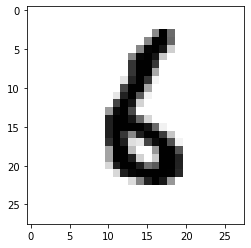

In [4]:
for data, label in train_loader:
    print (data.shape)
    print (label.shape)
    break

print (data.min())
print (data.max())

plt.imshow(data[0].numpy().squeeze(), cmap='gray_r')

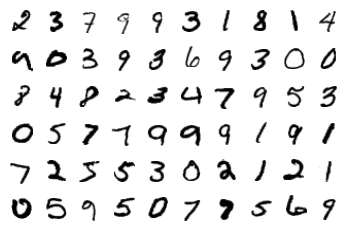

In [5]:
# Let's try to plot a few more images

figure = plt.figure()
num_of_images = 60
for index in range(1, num_of_images + 1):
    plt.subplot(6, 10, index)
    plt.axis('off')
    plt.imshow(data[index].numpy().squeeze(), cmap='gray_r')

In [75]:
# Awesome! Now let's try to build the model!

class MyNet(nn.Module):
    '''
    Class to define the neural network.
    '''
    def __init__(self):
        # In the following line, why is the first number 784? #sample of images
        # Remember what nn.Linear does? It's a fully connected layer.
        super(MyNet, self).__init__()
        self.conv1 = nn.Conv2d(1, 32, 5, stride=1, padding=2)
        self.conv2 = nn.Conv2d(32, 64, 5, stride=1, padding=2)
        
        self.drop_out = nn.Dropout()
        self.lin1 = nn.Linear(7 * 7 * 64, 1000)
        self.lin2 = nn.Linear(1000, 10)
        
#         self.conv1 = nn.Conv2d(1, 6, 5, stride=1)
#         self.conv2 = nn.Conv2d(6, 16, 5,stride=1)
#         self.conv3 = nn.Conv2d(16, 120, 5, stride=1) 16, 84 or 128? 
#         #flatten 
#         self.lin1 = nn.Linear(30720, 120) (128, 480)
#         self.lin2 = nn.Linear(120, 84)    (480, 10)
#         self.lin3 = nn.Linear(84, 10)

        
        
    
    def forward(self, x):
        # x has dimensions (batch_size, channel, height, width)
        # Here this becomes (128, 1, 28, 28)
#         print (x.shape)
        x = F.max_pool2d(F.relu(self.conv1(x)), (2, 2))
#         print ('After MP1')
#         print (x.shape)
        x = F.max_pool2d(F.relu(self.conv2(x)), (2, 2))
#         print (x.shape)
        x = x.reshape(x.size(0), -1)
#         print (x.shape)
        out = self.drop_out(x)
        x = self.lin1(x)
        x = self.lin2(x)
        
#         x = F.relu(self.conv1(x))
#         x = F.relu(self.conv2(x))
#         x = F.relu(self.conv3(x))
#         x = x.view(x.size(0), -1)
#         x = F.relu(self.lin1(x))
#         x = F.relu(self.lin2(x))
#         x = F.relu(self.lin3(x))
        
        return x

# Wanna try out a couple different architectures? Go nuts!
my_net = MyNet().to(device)

In [76]:
# Final ingredients before training starts off?
# Loss function and optimizer

cross_entropy_loss = nn.CrossEntropyLoss()
optimizer = optim.Adam(my_net.parameters(), lr=1e-4, weight_decay=1e-5) #weight decay 1e-4

In [77]:
# Alright! Training's good to go now!

epochs = 10

for epoch in range(epochs):
    epoch_loss = 0
    
    # In each epoch, we go through the entire dataset
    for data, label in train_loader:
        # 1. Move the data and label tensor to the device
        data = data.to(device)
        label = label.to(device)
        
        # 2. Clear optimizer gradients
        optimizer.zero_grad()
        
        # 3. Perform forward pass on the model
        net_output = my_net(data)
        
        # 4. Compute loss on the net_output comparing with target labels
        loss = cross_entropy_loss(net_output, label)
        
        # 5. Backpropagate to compute gradients throughout the network
        loss.backward()
        
        # 6. Take one gradient step!
        optimizer.step()

        # 7. Keep track of the loss function
        epoch_loss += loss

    print (f'Training epoch: {epoch}: Loss: {epoch_loss}')

print ('End of training!!')

Training epoch: 0: Loss: 156.10781860351562
Training epoch: 1: Loss: 38.95499038696289
Training epoch: 2: Loss: 28.059846878051758
Training epoch: 3: Loss: 22.77504539489746
Training epoch: 4: Loss: 19.04404640197754
Training epoch: 5: Loss: 16.340036392211914
Training epoch: 6: Loss: 13.978958129882812
Training epoch: 7: Loss: 12.137662887573242
Training epoch: 8: Loss: 10.846610069274902
Training epoch: 9: Loss: 9.6154203414917
End of training!!


torch.Size([128, 1, 28, 28])
Predicted Digit = 1


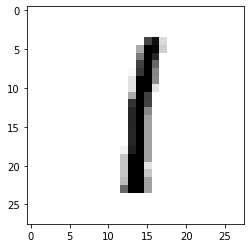

In [78]:
# Test on a single image from the test set

images, labels = next(iter(test_loader))
images = images.to(device)
labels = labels.to(device)

print (images.shape)
# img = images[0].view(1, 784)
with torch.no_grad():
    logps = my_net(images)

plt.imshow(images[0].cpu().numpy().squeeze(), cmap='gray_r')
ps = torch.exp(logps)
probab = list(ps.cpu().numpy()[0])
print("Predicted Digit =", probab.index(max(probab)))

In [79]:
# Let's now compute the overall accuracy on the test set!

from sklearn.metrics import accuracy_score
from sklearn.metrics import confusion_matrix


# Utility function which can be used to compute accuracy
def test_classification_net(model, data_loader, device):
    '''
    This function reports classification accuracy over a dataset.
    '''
    model.eval()
    labels_list = []
    predictions_list = []
    confidence_vals_list = []
    with torch.no_grad():
        for i, (data, label) in enumerate(data_loader):
            data = data.to(device)
            label = label.to(device)

            logits = model(data)
            softmax = F.softmax(logits, dim=1)
            confidence_vals, predictions = torch.max(softmax, dim=1)

            labels_list.extend(label.cpu().numpy().tolist())
            predictions_list.extend(predictions.cpu().numpy().tolist())
            confidence_vals_list.extend(confidence_vals.cpu().numpy().tolist())
    accuracy = accuracy_score(labels_list, predictions_list)

    return confusion_matrix(labels_list, predictions_list), accuracy

In [80]:
conf_matrix, accuracy = test_classification_net(my_net, test_loader, device)

In [89]:
print (conf_matrix)
print (f'Accuracy: {accuracy}')

[[ 976    0    0    0    0    1    1    1    1    0]
 [   0 1134    1    0    0    0    0    0    0    0]
 [   0    2 1027    0    0    0    0    2    1    0]
 [   1    0    0 1000    0    6    0    1    2    0]
 [   0    0    0    0  979    0    0    0    0    3]
 [   1    0    0    2    0  886    1    1    0    1]
 [   2    2    0    0    1    2  951    0    0    0]
 [   0    1    4    0    0    0    0 1022    1    0]
 [   3    0    2    1    0    2    1    3  959    3]
 [   0    3    0    0   11    4    0    7    1  983]]
Accuracy: 0.9917


In [90]:
# The confusion matrix shows which class has been classified as which class. Look it up!
# Hmm,... 97.21% test set accuracy after just 10 epochs of training. Not too bad!
# Can we improve on this? If so, how?

In [91]:
torch.save(my_net.state_dict(), 'conv_net_model.pt') #'OneDrive\Machine Learning' + 'conv_net_model.ckpt')